Rad229_EPI_Chemical_Shift_Demo.mlx demonstrates chemical shift effects in echo planar imaging (EPI).

These questions can be used to further explore the code and concepts.

1. Why are chemical shift artifacts less pronounced at lower B0?

2. Silicone has a very different chemical shift (+4.5ppm) compared to fat. How does this effect chemical shift artifacts?

3. What is the effect of chemical shift artifacts on a center-out EPI trajectory?

4. Add relaxation effects to see the impact on the point-spread-function.

4. [Advanced] Code up an example that demonstrates chemical shift artifacts from both fat and silicone in the same object.

5. [Advanced] Code up an example that includes a smooth distribution of fat off-resonance frequencies. How would you 
    describe the image artifacts? See: https://onlinelibrary.wiley.com/doi/pdf/10.1002/jmri.21895


DBE@STANFORD.EDU (April 2021) for Rad229

DBE@STANFORD.EDU (April 2025) Python version for Rad229

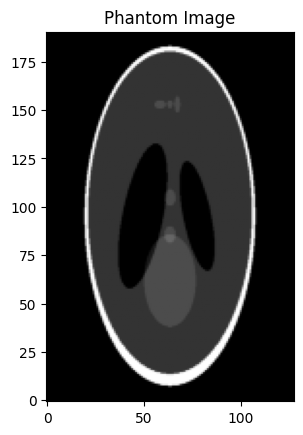

In [ ]:
# -- We use the functions in mrsigpy, as well as standard numpy and matpltlib
#! git clone https://github.com/mribri999/MRSignalsSeqs.git &> /dev/null # Clones the RAD229 repo
#import sys, os
#python_code_path = '/content/MRSignalsSeqs/Python/'
#sys.path.append(python_code_path) # To load the mrsigpy functions
#os.chdir(python_code_path) # Change directory to Python folder

import numpy as np
from Rad229_MRI_Phantom import rad229_mri_phantom
import matplotlib.pyplot as plt
from scipy.ndimage import shift

# System parameters
sys = {}
sys['B0'] = 3.0  # Magnetic field strength in Tesla
sys['gamma_bar'] = 42.57e6  # 1H gyromagnetic ratio in [Hz/T]

# Acquisition parameters
acq = {}
acq['Nx'] = 128
acq['Ny'] = 191
acq['ESP'] = 100e-6  # Echo spacing [s]

# Chemical shift parameters
obj = {}
obj['fat_ppm'] = -3.3e-6  # Chemical shift of fat [ppm]
obj['silicone_ppm'] = +4.5e-6  # Chemical shift of fat [ppm]
obj['dB0_fat'] = obj['fat_ppm'] * sys['B0']  # B0 shift [T]
obj['f_fat'] = sys['gamma_bar'] * obj['dB0_fat']  # Frequency offset [Hz]
obj['num'] = 2  # Identify phantom sub-object for fat ("skull")

# Generate a phantom object
phantom, mask = rad229_mri_phantom(acq)  # Make a Shepp-Logan phantom
phantom = np.array(phantom, dtype=complex)  # Cast phantom as complex

# Make figure of the phantom
plt.figure
plt.imshow(np.abs(phantom), cmap='gray', origin='lower');
plt.title('Phantom Image');

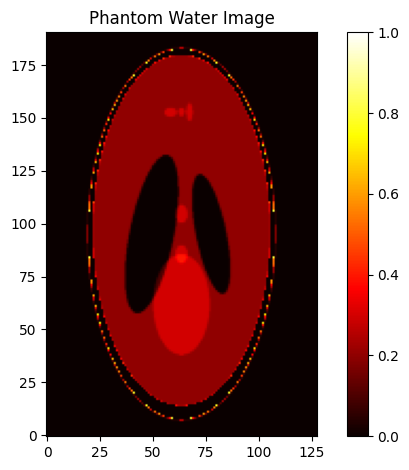

In [18]:
# Create water-only phantom by zeroing out the FAT region
P_water = phantom * (~mask[:, :, obj['num']])

# Compute k-space
kspc_water = np.fft.fftshift(np.fft.fft2(P_water))

# Reconstruct image of the water object
IM_water = np.fft.ifft2(np.fft.fftshift(kspc_water))

# Display the magnitude of the water-only phantom
plt.figure()
plt.imshow(np.abs(P_water), cmap='hot', aspect='equal', origin='lower')
plt.title('Phantom Water Image')
plt.colorbar()
plt.clim(0, 1)
plt.tight_layout()
plt.show()

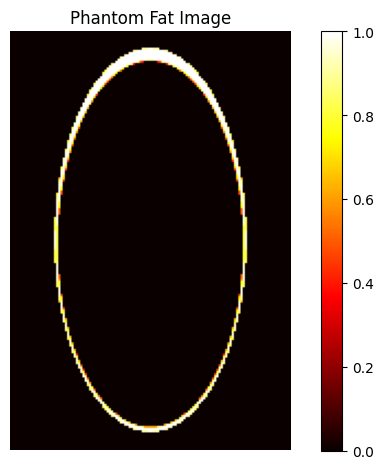

In [19]:
# Extract FAT part of the phantom
P_fat = phantom * mask[:, :, obj['num']]  # Element-wise multiplication

# Replicate P_fat along the third dimension for each echo time
P_fat = np.repeat(P_fat[:, :, np.newaxis], acq['Ny'], axis=2)

# Add phase to the FAT pixels per echo time
for n in range(acq['Ny']):
    phs_f = np.exp(-1j * 2 * np.pi * obj['f_fat'] * acq['ESP'] * (n + 1))
    P_fat[:, :, n] *= phs_f

# 4. Display the magnitude of the FAT image (first echo)
plt.figure()
plt.imshow(np.abs(P_fat[:, :, 0]), cmap='hot', aspect='equal')
plt.title('Phantom Fat Image')
plt.colorbar()
plt.clim(0, 1)
plt.axis('off')
plt.tight_layout()
plt.show()

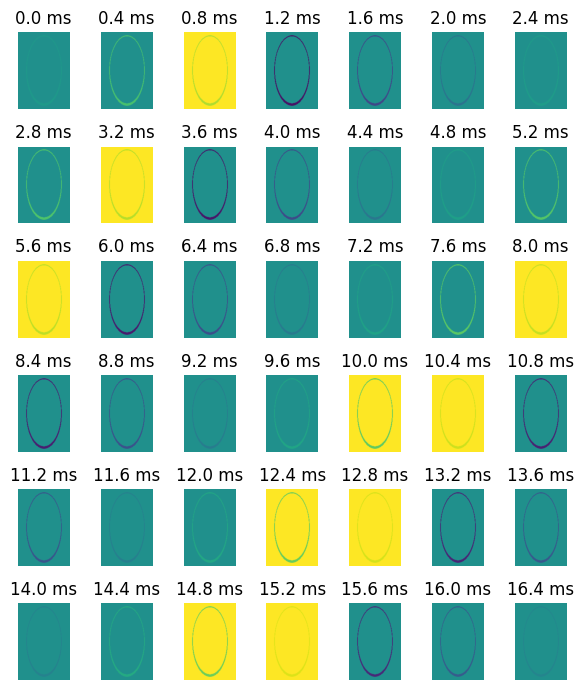

In [20]:
# Plot each n_sub phase in a subplot
n_sub = 4
n_rows = int(np.sqrt(acq['Ny'] / n_sub))
n_cols = n_rows + 1

# Plot the MAGNITUDE time-series
fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(n_rows, n_cols))
axes = axes.flatten()  # Flatten axes for easy iteration
n_axes = len(axes.flatten())
max_axes = acq['Ny'] // n_sub  # Maximum allowed axes
n_axes = min(n_axes, max_axes)  # Ensure n_axes doesn't exceed max_axes

for i in range(n_axes):
    ax = axes[i]
    ax.imshow(np.angle( P_fat[:, :, i * n_sub] ), vmin = -np.pi, vmax = +np.pi, cmap='viridis', origin='lower')
    ax.set_title(f"{i * n_sub * acq['ESP'] * 1000:.1f} ms")
    ax.axis('off')

plt.tight_layout()
plt.show()

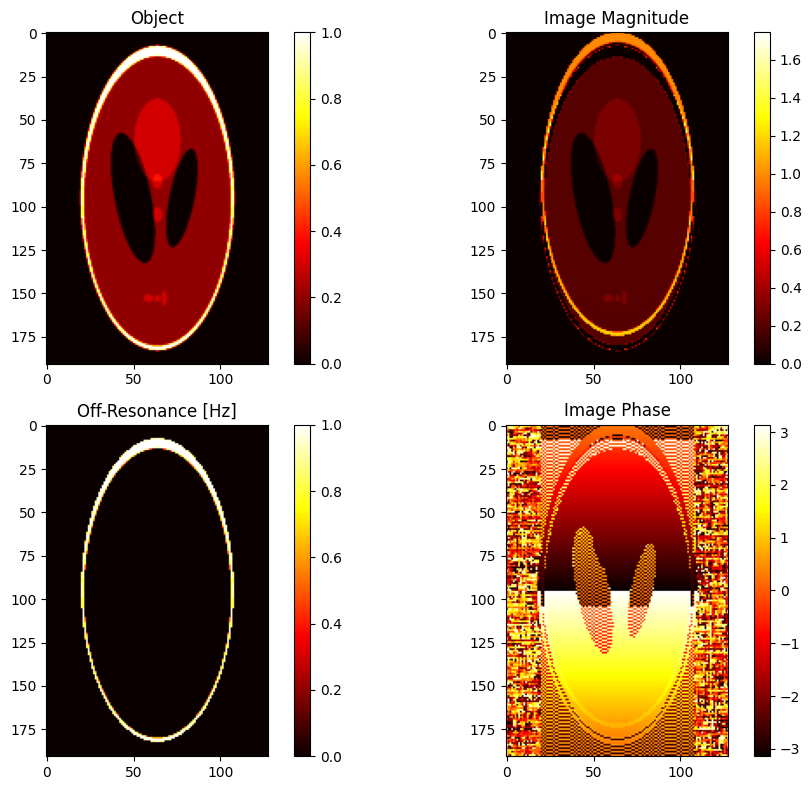

In [21]:
# Initialize k-space for the fat phantom (same size as P_fat)
kspc_fat = np.zeros_like(P_fat, dtype=complex)
kspc_fat_dist = np.zeros_like(P_fat[:, :, 0], dtype=complex)

# Perform 2D FFT for each echo in P_fat
for n in range(acq['Ny']):
    kspc_fat[:, :, n] = np.fft.fftshift(np.fft.fft2(P_fat[:, :, n]))

# Define the k-space ordering scheme
ind = np.arange(acq['Ny']) # TOP-DOWN k-space trajectory
#ind = acq['Ny'] - np.arange(acq['Ny']) - 1   # BOTTOM-UP k-space trajectory

for n in range(acq['Ny']):
    kspc_fat_dist[ind[n], :] = kspc_fat[ind[n], :, n]

# Reconstruct the distorted image
IM_fat_dist = np.fft.ifft2(np.fft.fftshift(kspc_fat_dist))

IM_final = IM_water + IM_fat_dist

# Show the results
plt.figure(figsize=(10, 8))
plt.set_cmap('hot')  # Set colormap to 'hot'

# Subplot 1: Magnitude of the object
plt.subplot(2, 2, 1)
plt.imshow(np.abs(phantom), aspect='equal')
plt.title('Object')
plt.colorbar()

# Subplot 2: Magnitude of the distorted image
plt.subplot(2, 2, 2)
plt.imshow(np.abs(IM_final), aspect='equal')
plt.title('Image Magnitude')
plt.colorbar()

# Subplot 3: Off-resonance map in Hz
plt.subplot(2, 2, 3)
plt.imshow(np.abs(P_fat[:, :, 0]), aspect='equal')
plt.title('Off-Resonance [Hz]')
plt.colorbar()

# Subplot 4: Phase of distorted image
plt.subplot(2, 2, 4)
plt.imshow(np.angle(IM_final), aspect='equal')
plt.title('Image Phase')
plt.colorbar()

plt.tight_layout()
plt.show()